In [1]:
#Start up Spark (only needs to be done once)
%reset
import os
import pyspark.sql
import sys
#from pyspark.sql.functions import abs
#from pyspark.sql.functions import cosh
#from pyspark.sql.functions import cos
#from pyspark.sql.functions import sqrt

#!export KRB5CCNAME=FILE:/tmp/${USER}_krb
#!kinit -c /tmp/${USER}_krb

session = pyspark.sql.SparkSession.builder \
    .master(
        #"spark://10.64.22.66:7077"
        "local"
    ) \
    .appName(# Name of your application in the dashboard/UI
             "Zpeak"
            ) \
    .config(# Tell Spark to load some extra libraries from Maven (the Java repository)
            'spark.jars.packages',
            'org.diana-hep:spark-root_2.11:0.1.16,org.diana-hep:histogrammar-sparksql_2.11:1.0.4'
            )\
    .config('spark.cores.max,3'
            ) \
    .getOrCreate()
    
sc = session.sparkContext
sqlContext = session
#!hdfs dfs -ls hdfs://10.64.22.72:9000/NANO_Prod

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


# Loading NanoAod root files using spark-root package
Loading the nanoaod root file serving from hadoop cluster, and load the tree in dedicated TDirectory in the root file.

In [8]:
filename="hdfs://10.64.22.72:9000/NANO_Prod/DYJetsToLL_M-50_TuneCUETP8M1_13TeV-madgraphMLM-pythia8_ext1-v2.root"
df = sqlContext.read.format("org.dianahep.sparkroot") \
    .option("tree","Events") \
    .load(filename)
#df = df.cache()
#df.printSchema() 

# User Defined Function Definition and helper function

User Defined Function (UDF) is a function passes row by row to compute derived quantity such as invaraint mass of two physics objects involving multiple column. Helper function defined to facilitate event selection (using spark feature such as filter instead of python defined function (thanks to NANOAOD structure!))

In [3]:
#Define function
#MuonEta = df.withColumn('Muon_eta[0]',abs(df.Value))
from ROOT import TLorentzVector, gROOT
lepton1 = TLorentzVector(); lepton1.SetPtEtaPhiM(0.,0.,0.,0.)
lepton2 = TLorentzVector(); lepton2.SetPtEtaPhiM(0.,0.,0.,0.)
Zsystem = TLorentzVector(); Zsystem.SetPtEtaPhiM(0.,0.,0.,0.)

def invariantMass(arr):
    lepton1.SetPtEtaPhiM(arr[0][0],arr[1][0],arr[2][0],arr[3][0])
    lepton2.SetPtEtaPhiM(arr[0][1],arr[1][1],arr[2][1],arr[3][1])
    Zsystem =lepton1+lepton2
    return float(Zsystem.M())

def passMuonSel(dataframe):
    return (dataframe.filter("Muon_pt[0]>10.0").filter("Muon_pfRelIso04_all[0]<0.12"))

def passEventSel(dataframe):
    return (dataframe.filter("nMuon>1").filter("Muon_pt[0]>25.0").filter("Muon_pfRelIso04_all[0]<0.5"))

Welcome to JupyROOT 6.08/00


# Event Selection

Physics object-oriented selection and general event selection. Note: eta selection is ommitted, the abs() feature is not permitted in spark filter. 

In [5]:
#muon selection
dfMuon = passMuonSel(df)
print "Muon Selection, number of event = ", dfMuon.count()
dfMuon = passEventSel(dfMuon)
print "General Event Selection, number of event = ", dfMuon.count()

Muon Selection, number of event =  151814
General Event Selection, number of event =  79794


# Computing the invaraince mass of two lepton 

Deploying the UDF to take kinemtaics variables of muons, constructing TLorenztVecotr on the fly and append a new column to reduced table (Muon object selection)

In [7]:
#header = list(df.columns)
#muonAttr = [muon for muon in header if 'Muon' in muon]
#dsMuons = df.select(muonAttr)

from pyspark.sql.functions import udf, array
from pyspark.sql.types import FloatType
MllUDF = udf(lambda z: invariantMass(z), FloatType())

dfMuon = dfMuon.withColumn('mll',MllUDF(array('Muon_pt','Muon_eta','Muon_phi','Muon_mass')))
#MLL = dfMuon.select(MllUDF(array('Muon_pt','Muon_eta','Muon_phi','Muon_mass')).alias('mll'))
#MLL.show(10)

dfMuon.select('mll').show(10)

+----------+
|       mll|
+----------+
|  92.16055|
|  78.37113|
|  65.17627|
|104.037766|
| 90.211586|
|  88.75579|
|  98.58132|
|  92.51027|
| 93.180214|
|  84.76843|
+----------+
only showing top 10 rows



# Plotting the invariance mass of Z boson (matplotlib)

Via Histogrammer, the computed quantity which appended to the big table is plotted using external package such as matplotlib

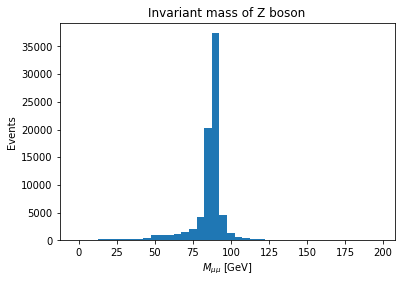

In [7]:
#make histogram using matplotlib
from histogrammar import *
import histogrammar.sparksql
import numpy as np
import matplotlib.pyplot as plt

#declaration of histogram
histogrammar.sparksql.addMethods(dfMuon)
hist = dfMuon.Bin(40, 0, 200, dfMuon['mll'])
plt.xlabel('$M_{\mu\mu}$ [GeV]')
plt.ylabel('Events')
hist.plot.matplotlib(name="Invariant mass of Z boson")

plt.show()

# Plotting the invariance mass of Z boson (root)

Via histogrammer, the computed quantity which appended to the big table is plotted using numpy + root packages

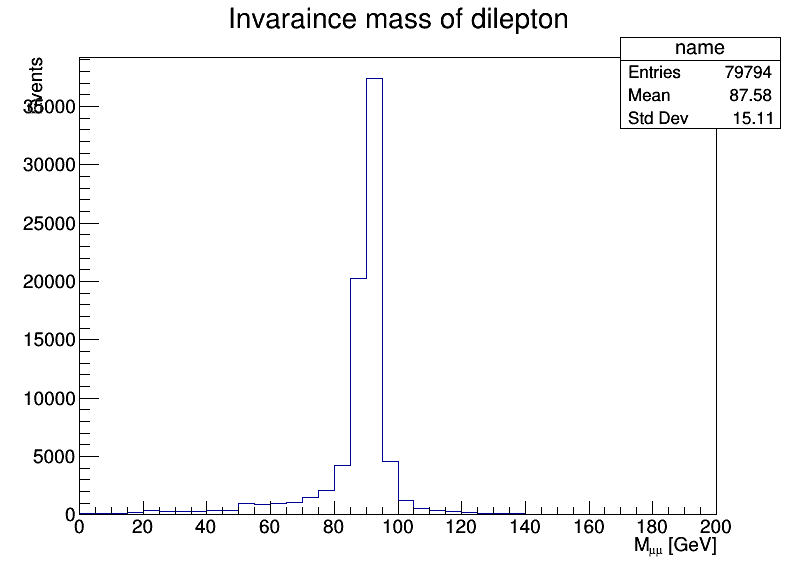

In [43]:
#Using numpy + pyroot 
from histogrammar import *
import ROOT
import numpy as np

mllp = np.array(dfMuon.select('mll').collect()).flatten()
histogram = Bin(40, 0, 200, lambda x : x )

histogram.fill.numpy(mllp)

c = ROOT.TCanvas("c1","The Canvas Title",800,600)
roothist = histogram.plot.root("name", "Invaraince mass of dilepton")
roothist.GetYaxis().SetTitle("Events")
roothist.GetXaxis().SetTitle("M_{#mu#mu} [GeV]")
roothist.Draw()
c.Draw()
#c.SaveAs("test.png")
